In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

In [2]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (round(x1), round(y1)), (round(x2), round(y2)), color, thickness)
            
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), min_line_len, max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

# Improve the draw_lines() function
def cal_slope(x1, y1, x2, y2):
    slope = (y2-y1)/(x2-x1)
    return slope

def extrapolate_x(x1, y1, bottom_y, top_y, slope):  # min = bottom, max = top
    top_x = ((top_y-y1)/slope) + x1  # (max_y-y1)/(max_x-x1) = slope
    bottom_x = x1 - ((y1-bottom_y)/slope)# (y1-bottom_y)/(x1-min_x) = slope
    return bottom_x, top_x

def full_extent_laneline(top_y, bottom_y, lines):
    right_line_num = 0
    right_line_bottom_x = 0
    right_line_top_x = 0
    left_line_num = 0
    left_line_bottom_x = 0
    left_line_top_x = 0
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = cal_slope(x1,y1,x2,y2)
            if slope > 0:
                right_line_num += 1
                bottom_x, top_x = extrapolate_x(x1, y1, bottom_y, top_y, slope)
                right_line_bottom_x += bottom_x
                right_line_top_x += top_x
            elif slope<0:
                left_line_num += 1
                bottom_x, top_x = extrapolate_x(x1, y1, bottom_y, top_y, slope)
                left_line_bottom_x += bottom_x
                left_line_top_x += top_x

    right_line_bottom_x = round(right_line_bottom_x/right_line_num)
    right_line_top_x = round(right_line_top_x/right_line_num)
    left_line_bottom_x = round(left_line_bottom_x/left_line_num)
    left_line_top_x = round(left_line_top_x/left_line_num)
    return np.array([[[right_line_top_x, top_y, right_line_bottom_x, bottom_y]],[[left_line_top_x, top_y, left_line_bottom_x, bottom_y]]])

def improve_hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, top_y, bottom_y, thickness):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), min_line_len, max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    full_lines = full_extent_laneline(top_y, bottom_y, lines)
    draw_lines(line_img, full_lines, thickness = thickness)
    return line_img

# improve improve 

def improve_full_extent_laneline(top_y, bottom_y, lines, imshape):
    line_threshold = 0.1*imshape[1]
    right_line_num = 0
    right_line_bottom_x = 0
    right_line_top_x = 0
    right_line_bottom_x_mean = 0
    right_line_top_x_mean = 0
    left_line_num = 0
    left_line_bottom_x = 0
    left_line_top_x = 0
    left_line_bottom_x_mean = 0
    left_line_top_x_mean = 0

    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = cal_slope(x1,y1,x2,y2)
            if slope > 0:
                bottom_x, top_x = extrapolate_x(x1, y1, bottom_y, top_y, slope)
                if imshape[1] >= bottom_x >= 0 and imshape[1] >= top_x >= 0:
                    if right_line_num == 0:
                        right_line_num = 1
                        right_line_bottom_x = bottom_x
                        right_line_bottom_x_mean = bottom_x
                        right_line_top_x = top_x
                        right_line_top_x_mean = top_x
                    elif abs(bottom_x-right_line_bottom_x_mean)<line_threshold and abs(top_x-right_line_top_x_mean)<line_threshold:
                        right_line_num += 1
                        right_line_bottom_x += bottom_x
                        right_line_top_x += top_x
                        right_line_bottom_x_mean = right_line_bottom_x/right_line_num
                        right_line_top_x_mean = right_line_top_x/right_line_num
            elif slope<0:
                bottom_x, top_x = extrapolate_x(x1, y1, bottom_y, top_y, slope)
                if imshape[1] >= bottom_x >= 0 and imshape[1] >= top_x >= 0:
                    if left_line_num ==0:
                        left_line_num = 1
                        left_line_bottom_x = bottom_x
                        left_line_bottom_x_mean = bottom_x
                        left_line_top_x = top_x
                        left_line_top_x_mean = top_x
                    elif abs(bottom_x-left_line_bottom_x_mean)<line_threshold and abs(top_x-left_line_top_x_mean)<line_threshold:
                        left_line_num += 1
                        left_line_bottom_x += bottom_x
                        left_line_top_x += top_x
                        left_line_bottom_x_mean = left_line_bottom_x/left_line_num
                        left_line_top_x_mean = left_line_top_x/left_line_num
    return np.array([[[right_line_top_x_mean, top_y, right_line_bottom_x_mean, bottom_y]],[[left_line_top_x_mean, top_y, left_line_bottom_x_mean, bottom_y]]])
    

def improve_improve_hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, top_y, bottom_y, thickness):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), min_line_len, max_line_gap)
    imshape = img.shape
    line_img = np.zeros((imshape[0], imshape[1], 3), dtype=np.uint8)
    full_lines = improve_full_extent_laneline(top_y, bottom_y, lines, imshape)
    draw_lines(line_img, full_lines, thickness = thickness)
    return line_img

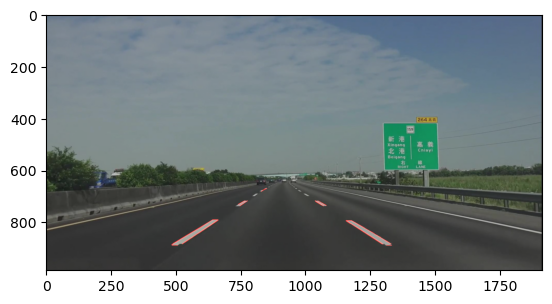

In [3]:
# Read in and grayscale the image
image = mpimg.imread('./20240312PERCEPTION_FOR_AUTONOMOUS_CARS2/test.jpg')
gray = grayscale(image)
kernel_size = 3
blur_gray = gaussian_blur(gray, kernel_size)
low_threshold = 50
high_threshold = 150
edges = canny(blur_gray, low_threshold, high_threshold)
imshape = image.shape
vertices = np.array([[(250, imshape[0]), (1750, imshape[0]), (950,670), (850,670)]], dtype=np.int32)  # 逆時針
masked_edges = region_of_interest(edges, vertices)
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 1     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 15 #minimum number of pixels making up a line
max_line_gap = 10    # maximum gap in pixels between connectable line segments

# 
line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)
line_img = np.zeros((masked_edges.shape[0], masked_edges.shape[1], 3), dtype=np.uint8)

#
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_img, (x1, y1), (x2, y2), [255, 0, 0], 10)
#
result = weighted_img(line_image, image, α=0.8, β=1., γ=0.)

#
plt.figure()
plt.imshow(result)
plt.show()

In [4]:
def cal_slope(x1, y1, x2, y2):
    if x1==x2:
        print("x same")
    slope = (y2-y1)/(x2-x1)
    return slope

def extrapolate_x(x1, y1, bottom_y, top_y, slope):  # min = bottom, max = top
    top_x = ((top_y-y1)/slope) + x1  # (max_y-y1)/(max_x-x1) = slope
    bottom_x = x1 - ((y1-bottom_y)/slope)# (y1-bottom_y)/(x1-min_x) = slope
    return bottom_x, top_x


In [5]:
def full_extent_laneline(top_y, bottom_y, lines):
    right_line_num = 0
    right_line_bottom_x = 0
    right_line_top_x = 0
    left_line_num = 0
    left_line_bottom_x = 0
    left_line_top_x = 0
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = cal_slope(x1,y1,x2,y2)
            if slope > 0:
                right_line_num += 1
                bottom_x, top_x = extrapolate_x(x1, y1, bottom_y, top_y, slope)
                right_line_bottom_x += bottom_x
                right_line_top_x += top_x
            elif slope < 0:
                left_line_num += 1
                bottom_x, top_x = extrapolate_x(x1, y1, bottom_y, top_y, slope)
                left_line_bottom_x += bottom_x
                left_line_top_x += top_x

    right_line_bottom_x = round(right_line_bottom_x/right_line_num)
    right_line_top_x = round(right_line_top_x/right_line_num)
    left_line_bottom_x = round(left_line_bottom_x/left_line_num)
    left_line_top_x = round(left_line_top_x/left_line_num)
    return np.array([[[right_line_top_x, top_y, right_line_bottom_x, bottom_y]],[[left_line_top_x, top_y, left_line_bottom_x, bottom_y]]])

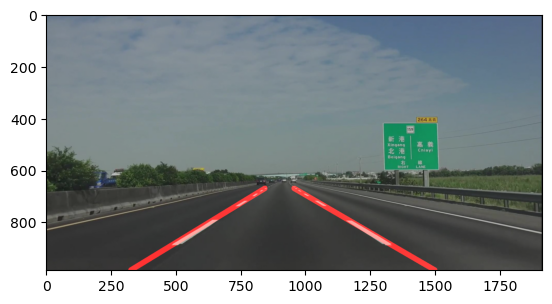

In [6]:
# Read in and grayscale the image
image = mpimg.imread('./20240312PERCEPTION_FOR_AUTONOMOUS_CARS2/test.jpg')
gray = grayscale(image)
kernel_size = 3
blur_gray = gaussian_blur(gray, kernel_size)
low_threshold = 50
high_threshold = 150
edges = canny(blur_gray, low_threshold, high_threshold)
imshape = image.shape
vertices = np.array([[(250, imshape[0]), (1750, imshape[0]), (950,670), (850,670)]], dtype=np.int32)  # 逆時針
masked_edges = region_of_interest(edges, vertices)
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 1     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 15 #minimum number of pixels making up a line
max_line_gap = 10    # maximum gap in pixels between connectable line segments

# 
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)
line_img = np.zeros((masked_edges.shape[0], masked_edges.shape[1], 3), dtype=np.uint8)

#
full_lines = full_extent_laneline(670, 985, lines)
for line in full_lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_img, (x1, y1), (x2, y2), [255, 0, 0], 20)

#cv2.line(line_img, (right_line_top_x_mean, top_y), (right_line_bottom_x_mean, bottom_y), [255, 0, 0], 20)
#cv2.line(line_img, (left_line_top_x_mean, top_y), (left_line_bottom_x_mean, bottom_y), [255, 0, 0], 20)
#
result = weighted_img(line_img, image, α=0.8, β=1., γ=0.)

#
plt.figure()
plt.imshow(result)
plt.show()

In [7]:
bottom_y = 985
top_y = 670
line_threshold = 0.1*image.shape[1]

right_line_num = 0
right_line_bottom_x = 0
right_line_top_x = 0
right_line_bottom_x_mean = 0
right_line_top_x_mean = 0

left_line_num = 0
left_line_bottom_x = 0
left_line_top_x = 0
left_line_bottom_x_mean = 0
left_line_top_x_mean = 0

for line in lines:
    for x1,y1,x2,y2 in line:
        slope = cal_slope(x1,y1,x2,y2)
        if slope > 0:
            bottom_x, top_x = extrapolate_x(x1, y1, bottom_y, top_y, slope)
            print("1right_line_num, bottom_x, top_x = ",right_line_num, bottom_x, top_x)
            if right_line_num == 0:
                right_line_num = 1
                right_line_bottom_x = bottom_x
                right_line_bottom_x_mean = bottom_x
                right_line_top_x = top_x
                right_line_top_x_mean = top_x
                print("2right_line_num, right_line_bottom_x_mean, right_line_top_x_mean = ",right_line_num, right_line_bottom_x_mean, right_line_top_x_mean)
            elif abs(bottom_x-right_line_bottom_x_mean)<line_threshold and abs(top_x-right_line_top_x_mean)<line_threshold:
                print("in")
                right_line_num += 1
                right_line_bottom_x += bottom_x
                print(right_line_bottom_x)
                right_line_top_x += top_x
                print(right_line_top_x)
                right_line_bottom_x_mean = round(right_line_bottom_x/right_line_num)
                print(right_line_bottom_x_mean)
                right_line_top_x_mean = round(right_line_top_x/right_line_num)
                print(right_line_top_x_mean)
                print("2right_line_num, right_line_bottom_x_mean, right_line_top_x_mean = ",right_line_num, right_line_bottom_x_mean, right_line_top_x_mean)
        elif slope<0:
            bottom_x, top_x = extrapolate_x(x1, y1, bottom_y, top_y, slope)
            if left_line_num ==0:
                left_line_num = 1
                left_line_bottom_x = bottom_x
                left_line_bottom_x_mean = bottom_x
                left_line_top_x = top_x
                left_line_top_x_mean = top_x

            elif abs(bottom_x-left_line_bottom_x_mean)<line_threshold and abs(top_x-left_line_top_x_mean)<line_threshold:
                left_line_num += 1
                left_line_bottom_x += bottom_x
                left_line_top_x += top_x
                left_line_bottom_x_mean = round(left_line_bottom_x/left_line_num)
                left_line_top_x_mean = round(left_line_top_x/left_line_num)
            print("left_line_num, left_line_bottom_x_mean, left_line_top_x_mean = ",left_line_num, left_line_bottom_x_mean, left_line_top_x_mean)
            print("left_line_num, bottom_x, top_x = ",left_line_num, bottom_x, top_x)


left_line_num, left_line_bottom_x_mean, left_line_top_x_mean =  1 376.28571428571433 845.0357142857142
left_line_num, bottom_x, top_x =  1 376.28571428571433 845.0357142857142
1right_line_num, bottom_x, top_x =  0 1538.5 961.0
2right_line_num, right_line_bottom_x_mean, right_line_top_x_mean =  1 1538.5 961.0
1right_line_num, bottom_x, top_x =  1 1520.0714285714284 957.5714285714286
in
3058.5714285714284
1918.5714285714284
1529
959
2right_line_num, right_line_bottom_x_mean, right_line_top_x_mean =  2 1529 959
1right_line_num, bottom_x, top_x =  2 1457.060606060606 965.469696969697
in
4515.632034632034
2884.0411255411254
1505
961
2right_line_num, right_line_bottom_x_mean, right_line_top_x_mean =  3 1505 961
left_line_num, left_line_bottom_x_mean, left_line_top_x_mean =  2 348 846
left_line_num, bottom_x, top_x =  2 319.2608695652174 846.5434782608695
1right_line_num, bottom_x, top_x =  3 1452.9888888888888 966.4888888888888
in
5968.6209235209235
3850.5300144300145
1492
963
2right_line_nu

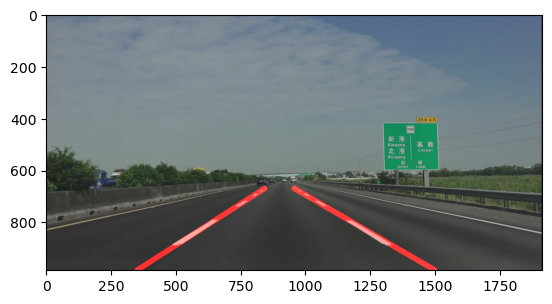

In [8]:
# Read in and grayscale the image
image = mpimg.imread('./20240312PERCEPTION_FOR_AUTONOMOUS_CARS2/test.jpg')
gray = grayscale(image)
kernel_size = 3
blur_gray = gaussian_blur(gray, kernel_size)
low_threshold = 50
high_threshold = 150
edges = canny(blur_gray, low_threshold, high_threshold)
imshape = image.shape
vertices = np.array([[(250, imshape[0]), (1750, imshape[0]), (950,670), (850,670)]], dtype=np.int32)  # 逆時針
masked_edges = region_of_interest(edges, vertices)
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 1     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 15 #minimum number of pixels making up a line
max_line_gap = 10    # maximum gap in pixels between connectable line segments

# 
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)
line_img = np.zeros((masked_edges.shape[0], masked_edges.shape[1], 3), dtype=np.uint8)

#

cv2.line(line_img, (right_line_top_x_mean, top_y), (right_line_bottom_x_mean, bottom_y), [255, 0, 0], 20)
cv2.line(line_img, (left_line_top_x_mean, top_y), (left_line_bottom_x_mean, bottom_y), [255, 0, 0], 20)
#
result = weighted_img(line_img, image, α=0.8, β=1., γ=0.)

#
plt.figure()
plt.imshow(result)
plt.show()

In [ ]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
dir = "test_images/"
test_images = os.listdir(dir)
for test_image in test_images:
    image = mpimg.imread(os.path.join(dir,test_image))

    # 
    gray = grayscale(image)
    kernel_size = 3
    blur_gray = gaussian_blur(gray, kernel_size)
    low_threshold = 60
    high_threshold = 180
    edges = canny(blur_gray, low_threshold, high_threshold)
    imshape = image.shape
    vertices = np.array([[(60, imshape[0]), (900, imshape[0]), (550,330), (410,330)]], dtype=np.int32)  # 逆時針
    masked_edges = region_of_interest(edges, vertices)
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 50     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 20 #minimum number of pixels making up a line
    max_line_gap = 10    # maximum gap in pixels between connectable line segments
    # line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    # line_image = improve_hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap, 330, imshape[0], 20)
    line_image = improve_improve_hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap, 330, imshape[0], 20)
    result = weighted_img(line_image, image, α=0.8, β=1., γ=0.)

    #
    plt.figure()
    plt.imshow(result)
plt.show()

In [ ]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    # grayscale the image
    gray = grayscale(image)
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)
    low_threshold = 60
    high_threshold = 180
    edges = canny(blur_gray, low_threshold, high_threshold)
    imshape = image.shape
    vertices = np.array([[(60, imshape[0]), (900, imshape[0]), (550,330), (410,330)]], dtype=np.int32)  # 逆時針
    masked_edges = region_of_interest(edges, vertices)
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 20     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 20 #minimum number of pixels making up a line
    max_line_gap = 10    # maximum gap in pixels between connectable line segments
    # line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    #line_image = improve_hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap, 330, imshape[0], 20)
    line_image = improve_improve_hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap, 330, imshape[0], 20)
    result = weighted_img(line_image, image, α=0.8, β=1., γ=0.)
    return result

In [ ]:
def yellow_filter(img):
    yellow_thresholds = (img[:,:,0] > 160) & \
                    (img[:,:,1] > 160) & \
                    (img[:,:,2] < 120)
    white_thresholds = (img[:,:,0] > 180) & \
                    (img[:,:,1] > 180) & \
                    (img[:,:,2] > 180)
    img[yellow_thresholds] = [255, 255, 255]
    #img[white_thresholds] = [255, 255, 255]
    return img

In [ ]:
from PIL import Image, ImageEnhance
def img_enhance(img):
    img = Image.fromarray(img,'RGB')
    contrast = ImageEnhance.Contrast(img)
    output = contrast.enhance(2) 
    return np.array(output)

In [ ]:
for i in range(10):
    filename = os.path.join(r"D:/桌面/1122_autonomous cars/Project1/challenge_frame"+str(i)+'.jpg')
    image = mpimg.imread(filename)
    yellow_select= np.copy(image)
    yellow_select = yellow_filter(yellow_select)
    plt.figure()
    plt.imshow(yellow_select)
    #color_select = img_enhance(color_select)
    #plt.figure()
    #plt.imshow(color_select)
    gray = grayscale(yellow_select)
    kernel_size = 3
    blur_gray = gaussian_blur(gray, kernel_size)
    low_threshold = 70
    high_threshold = 210
    edges = canny(blur_gray, low_threshold, high_threshold)
    imshape = image.shape
    vertices = np.array([[(60, 660), (1220, 660), (680,450), (600,450)]], dtype=np.int32)  # 逆時針
    masked_edges = region_of_interest(edges, vertices)
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 30     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 30 #minimum number of pixels making up a line
    max_line_gap = 5    # maximum gap in pixels between connectable line segments
    hough_line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    result = weighted_img(hough_line_image, image, α=0.8, β=1., γ=0.)
    plt.figure()
    plt.imshow(result)
    line_image = improve_improve_hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap, 450, imshape[0], 20)
    result = weighted_img(line_image, image, α=0.8, β=1., γ=0.)

    #
    plt.figure()
    plt.imshow(result)
plt.show()